# Advanced CNN model
## Importing the models
Handling the essential setup for a reproducible deep learning environment. Import TensorFlow and Keras for building and training neural networks, along with supporting libraries for data visualization and performance evaluation. The random seed initialization ensures consistent results across multiple runs by controlling the randomness in numerical computations and model weight initialization.

In [1]:
# Importing libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)


2025-10-05 20:07:45.637320: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/Zhuanz/formative2group4/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Data Augmentation Strategy

To enhance the robustness and generalization capabilities of the advanced CNN model, a comprehensive data augmentation strategy is implemented. This involves applying a series of random transformations to the training images during the training process. The `ImageDataGenerator` class from TensorFlow Keras is utilized for this purpose.

The following transformations are applied to the training data:

- **Rescaling:** Pixel values are scaled to the range [0, 1] by dividing by 255.
- **Rotation:** Images are randomly rotated by up to 15 degrees.
- **Width and Height Shift:** Images are randomly shifted horizontally and vertically by up to 15% of their width and height, respectively.
- **Shear:** Shear transformations are applied with a shear intensity of up to 15 degrees.
- **Zoom:** Images are randomly zoomed in or out by up to 15%.
- **Horizontal Flip:** Images are randomly flipped horizontally.
- **Fill Mode:** Pixels outside the boundaries after transformations are filled using the 'nearest' strategy.

These transformations create variations of the existing training data, effectively increasing the size and diversity of the training dataset. This helps the model learn more invariant features and reduces the risk of overfitting to the specific characteristics of the original training images.

A separate `ImageDataGenerator` is used for the validation and test sets, with only rescaling applied, to ensure that the model's performance is evaluated on unseen, untransformed data.

In [2]:
# defining image size 
IMG_SIZE = 128  
BATCH_SIZE = 64  

# data augmentation which means generating new training data from existing training data by applying random transformations
# to help the model generalize better and reduce overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,  #
    width_shift_range=0.15, 
    height_shift_range=0.15, 
    shear_range=0.15,  
    zoom_range=0.15,  
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
# Create data generators which will read images from the directory, apply transformations, and yield batches of images and labels
train_gen = train_datagen.flow_from_directory(
    'data_split/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    'data_split/val',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_gen = val_datagen.flow_from_directory(
    'data_split/test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print(f"Classes: {train_gen.class_indices}")
print(f"Training samples: {train_gen.samples}")

Found 19290 images belonging to 2 classes.
Found 4134 images belonging to 2 classes.
Found 4134 images belonging to 2 classes.
Classes: {'Parasitized': 0, 'Uninfected': 1}
Training samples: 19290


## Advanced CNN Architecture

An advanced Convolutional Neural Network (CNN) architecture has been designed and implemented with optimizations aimed at achieving faster training convergence while maintaining high performance. The model is constructed using the Keras Sequential API, incorporating several key layers to effectively process image data.

The architecture consists of the following layers:

- **Input Layer:** Specifies the input shape for the images, which is set to (IMG_SIZE, IMG_SIZE, 3) to accommodate images of a defined size with three color channels (RGB).

- **Convolutional Blocks:** The model utilizes four convolutional blocks. Each block typically includes:
    - **Conv2D:** Convolutional layers with ReLU activation and 'same' padding to extract features from the input images. The number of filters increases in subsequent blocks (32, 64, 128, 256).
    - **BatchNormalization:** Applied after each convolutional layer to normalize the activations, which helps in stabilizing and accelerating the training process.
    - **MaxPooling2D:** Used to downsample the feature maps, reducing the spatial dimensions and computational complexity while retaining important features.
    - **Dropout:** Implemented after the pooling layers to randomly set a fraction of input units to zero during training, which acts as a regularization technique to prevent overfitting. The dropout rate is slightly increased in later blocks (0.25, 0.25, 0.3, 0.3).

- **Output Layer:** A dense layer with a single unit and a sigmoid activation function is used for binary classification. The sigmoid function outputs a value between 0 and 1, representing the probability of the positive class.


In [4]:
# Building an advanced CNN architecture with optimizations for faster training
def build_advanced_cnn():
    """Create optimized CNN for faster training"""
    
    model = keras.Sequential()
    
    # Input layer
    model.add(layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
    
    # Block 1 - Smaller filters initially
    model.add(layers.Conv2D(32, 3, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Dropout(0.25))
    
    # Block 2
    model.add(layers.Conv2D(64, 3, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Dropout(0.25))
    
    # Block 3
    model.add(layers.Conv2D(128, 3, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Dropout(0.3))
    
    # Block 4 - Deeper features + pooling before dense
    model.add(layers.Conv2D(128, 3, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    
    # Output layer (for binary classification)
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model


# Build and display model
fast_model = build_advanced_cnn()
print("\nOptimized Model Architecture:")
fast_model.summary()



Optimized Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,369 (946.75 KB)

 Trainable params: 241,665 (944.00 KB)

 Non-trainable params: 704 (2.75 KB)

## Model Configuration

The advanced CNN model is configured for training with optimized settings to facilitate faster convergence and improve performance.

- **Optimizer:** The Adam optimizer is selected with a specified learning rate (defaulting to 0.001) and default values for beta_1, beta_2, and epsilon. Adam is an adaptive learning rate optimization algorithm that is widely used for training deep neural networks due to its efficiency and effectiveness.

- **Loss Function:** Binary cross-entropy is chosen as the loss function. This is a standard loss function for binary classification problems, measuring the difference between the predicted probabilities and the true binary labels.

- **Metrics:** The model is configured to track several important metrics during training and evaluation, including:
    - **Accuracy:** The proportion of correctly classified instances.
    - **Precision:** The ability of the model to identify only relevant instances (true positives out of all positive predictions).
    - **Recall:** The ability of the model to find all relevant instances (true positives out of all actual positives).



In [5]:
# configure the model with optimized settings

def configure_advanced_model(model, learning_rate=0.001):
    """Configure model with optimized settings"""
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=learning_rate,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-07
        ),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    return model


In [6]:
def run_fast_training(model, epochs=20):
    """Optimized training with faster convergence - FIXED"""
    
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',  
            patience=6,  
            restore_best_weights=True,
            min_delta=0.001  
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,  
            min_lr=1e-7,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            'advanced_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=0
        )
    ]
    
    print("\n Starting optimized training...")
    
    # Calculate steps per epoch
    steps_per_epoch = max(1, train_gen.samples // BATCH_SIZE)
    validation_steps = max(1, val_gen.samples // BATCH_SIZE)
    

    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_gen,
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=1
    )
    
    return history

## Model Evaluation and Metric Calculation

To assess the performance of the trained advanced CNN model, a dedicated function is implemented for efficient evaluation. This function takes the trained model and the test data generator as input and computes essential classification metrics.

The evaluation process involves the following steps:

- **Prediction:** The model predicts the class probabilities for the images in the test dataset using a larger batch size (`BATCH_SIZE*2`) for faster processing.
- **Class Conversion:** The predicted probabilities are converted into binary class labels by applying a threshold of 0.5.
- **Metric Calculation:** The function calculates the following key performance metrics using the true class labels from the test data and the predicted class labels:
    - **Accuracy:** The overall proportion of correctly classified instances.
    - **Precision:** The ability of the model to avoid false positives.
    - **Recall:** The ability of the model to find all positive instances.
    - **F1-Score:** The harmonic mean of precision and recall, providing a balanced measure of the model's performance.


In [7]:
def calculating_metrics(model, test_data):
    """Fast metric calculation"""
    
    print("🔍 Running fast evaluation...")
    
    # Use larger batch size for faster prediction
    predictions = model.predict(test_data, batch_size=BATCH_SIZE*2, verbose=1)
    predicted_classes = (predictions > 0.5).astype(int).flatten()
    true_classes = test_data.classes
    
    # Calculate only essential metrics initially
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes)
    recall = recall_score(true_classes, predicted_classes)
    f1 = f1_score(true_classes, predicted_classes)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': predictions,
        'true_classes': true_classes
    }


## Visualization

To provide a clear understanding of the advanced CNN model's performance and training progress results as input and produces a single figure with multiple subplots:

- **Accuracy Plot:** Displays the training and validation accuracy across epochs, allowing for the assessment of the model's learning trend and potential overfitting.
- **Loss Plot:** Shows the training and validation loss over epochs, indicating how well the model is converging and minimizing errors.
- **Test Metrics Bar Chart:** Presents a bar chart comparing the key performance metrics (Accuracy, Precision, Recall, and F1-Score) on the test set. This provides a concise summary of the model's performance on unseen data. The values of each metric are displayed on top of the bars for easy interpretation.
- **ROC Curve:** Plots the Receiver Operating Characteristic (ROC) curve, which illustrates the trade-off between the true positive rate (sensitivity) and the false positive rate (1-specificity) at various threshold settings. The Area Under the Curve (AUC) is calculated and displayed, providing a single scalar value that summarizes the overall discriminatory power of the model.



In [8]:
def create_visualizations(history, results):
    """Create essential visualizations only"""
    
    # Single figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
    
    # Accuracy
    ax1.plot(history.history['accuracy'], label='Train', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Val', linewidth=2)
    ax1.set_title('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Loss
    ax2.plot(history.history['loss'], label='Train', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Val', linewidth=2)
    ax2.set_title('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Metrics comparison
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
    values = [results['accuracy'], results['precision'], 
             results['recall'], results['f1_score']]
    
    bars = ax3.bar(metrics, values, color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'])
    ax3.set_title('Test Metrics')
    ax3.set_ylim(0, 1)
    
    # Add values on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom')
    
    # ROC Curve (only if needed)
    fpr, tpr, _ = roc_curve(results['true_classes'], results['predictions'])
    roc_auc = auc(fpr, tpr)
    
    ax4.plot(fpr, tpr, color='darkorange', linewidth=2, 
             label=f'AUC = {roc_auc:.3f}')
    ax4.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    ax4.set_title('ROC Curve')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('fast_model_results.png', dpi=150, bbox_inches='tight')  # Lower DPI
    plt.show()


⚡ Starting OPTIMIZED CNN Training...

 Starting optimized training...


/Users/Zhuanz/formative2group4/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7268 - loss: 0.5369 - precision: 0.7039 - recall: 0.7826

301/301 ━━━━━━━━━━━━━━━━━━━━ 782s 3s/step - accuracy: 0.7271 - loss: 0.5365 - precision: 0.7042 - recall: 0.7829 - val_accuracy: 0.4883 - val_loss: 1.4143 - val_precision: 0.4309 - val_recall: 0.1030 - learning_rate: 0.0010
Epoch 2/20
  1/301 ━━━━━━━━━━━━━━━━━━━━ 12:27 2s/step - accuracy: 0.8750 - loss: 0.3462 - precision: 0.8537 - recall: 0.9459

/Users/Zhuanz/formative2group4/.venv/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


301/301 ━━━━━━━━━━━━━━━━━━━━ 36s 110ms/step - accuracy: 0.8750 - loss: 0.3462 - precision: 0.8537 - recall: 0.9459 - val_accuracy: 0.4880 - val_loss: 1.6168 - val_precision: 0.4050 - val_recall: 0.0715 - learning_rate: 0.0010
Epoch 3/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9099 - loss: 0.2476 - precision: 0.8790 - recall: 0.9535

301/301 ━━━━━━━━━━━━━━━━━━━━ 851s 3s/step - accuracy: 0.9099 - loss: 0.2476 - precision: 0.8790 - recall: 0.9535 - val_accuracy: 0.5339 - val_loss: 2.4085 - val_precision: 0.7419 - val_recall: 0.0907 - learning_rate: 0.0010
Epoch 4/20
  1/301 ━━━━━━━━━━━━━━━━━━━━ 13:39 3s/step - accuracy: 0.9219 - loss: 0.1806 - precision: 0.9032 - recall: 0.9333
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


301/301 ━━━━━━━━━━━━━━━━━━━━ 42s 130ms/step - accuracy: 0.9219 - loss: 0.1806 - precision: 0.9032 - recall: 0.9333 - val_accuracy: 0.5444 - val_loss: 1.6247 - val_precision: 0.7185 - val_recall: 0.1321 - learning_rate: 0.0010
Epoch 5/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9297 - loss: 0.2052 - precision: 0.9010 - recall: 0.9640

301/301 ━━━━━━━━━━━━━━━━━━━━ 795s 3s/step - accuracy: 0.9297 - loss: 0.2052 - precision: 0.9010 - recall: 0.9640 - val_accuracy: 0.9207 - val_loss: 0.2483 - val_precision: 0.9347 - val_recall: 0.9029 - learning_rate: 5.0000e-04
Epoch 6/20
  1/301 ━━━━━━━━━━━━━━━━━━━━ 12:03 2s/step - accuracy: 0.8906 - loss: 0.2439 - precision: 0.8000 - recall: 0.9600

301/301 ━━━━━━━━━━━━━━━━━━━━ 29s 87ms/step - accuracy: 0.8906 - loss: 0.2439 - precision: 0.8000 - recall: 0.9600 - val_accuracy: 0.9402 - val_loss: 0.2261 - val_precision: 0.9360 - val_recall: 0.9438 - learning_rate: 5.0000e-04
Epoch 7/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 698s 2s/step - accuracy: 0.9305 - loss: 0.2013 - precision: 0.9035 - recall: 0.9638 - val_accuracy: 0.9058 - val_loss: 0.2281 - val_precision: 0.8447 - val_recall: 0.9921 - learning_rate: 5.0000e-04
Epoch 8/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 36s 112ms/step - accuracy: 0.9844 - loss: 0.0923 - precision: 0.9667 - recall: 1.0000 - val_accuracy: 0.8992 - val_loss: 0.2465 - val_precision: 0.8347 - val_recall: 0.9931 - learning_rate: 5.0000e-04
Epoch 9/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9335 - loss: 0.1950 - precision: 0.9084 - recall: 0.9644
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
301/301 ━━━━━━━━━━━━━━━━━━━━ 1115s 4s/step - accuracy: 0.9335 - loss: 0.1950 - precision: 0.9

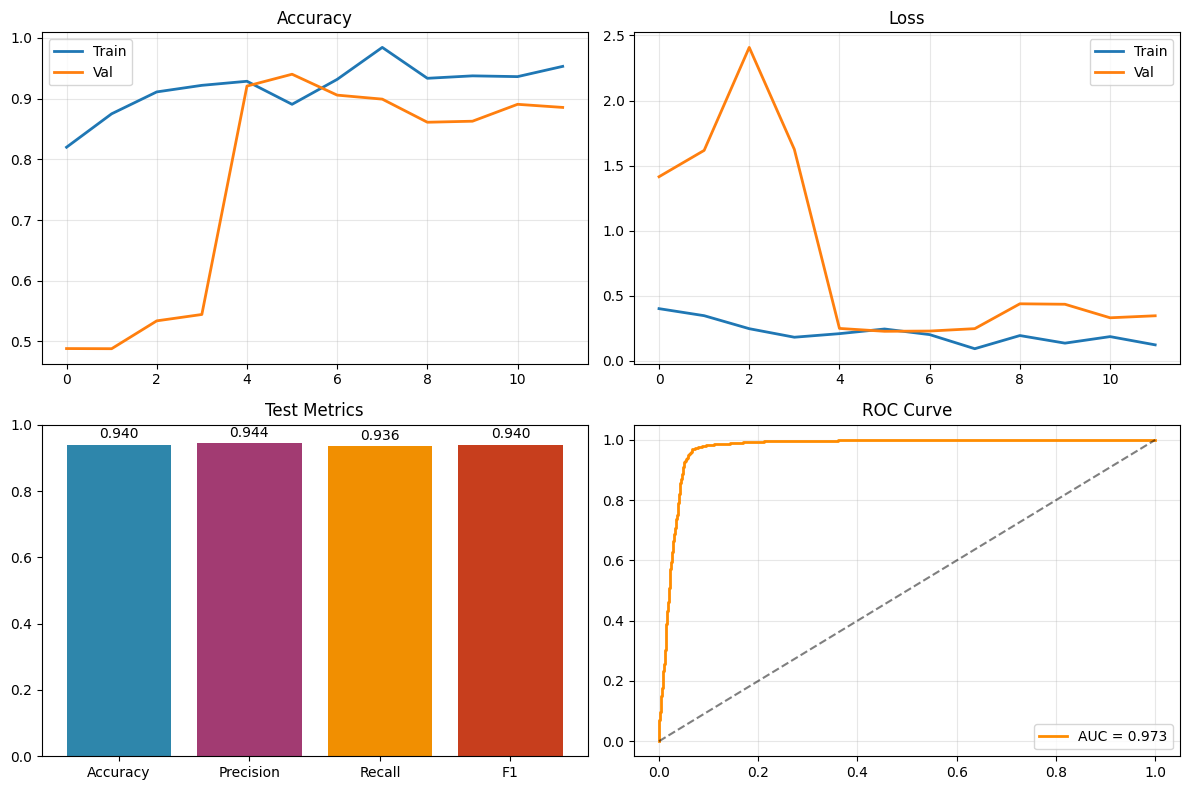


 Model saved as 'advanced_cnn.h5'

 Optimized training complete in 88.2 minutes!


In [9]:

def main_fast():
    """Optimized main execution"""
    
    import time
    start_time = time.time()
    
    print("⚡ Starting OPTIMIZED CNN Training...")
    
    # Build and configure model
    fast_model = build_advanced_cnn()
    fast_model = configure_advanced_model(fast_model, learning_rate=0.001)
    
    # Train model
    training_history = run_fast_training(fast_model, epochs=20)
    
    # Evaluate model
    print("\n📊 Running fast evaluation...")
    model_results = calculating_metrics(fast_model, test_gen)
    
    # Calculate execution time
    end_time = time.time()
    execution_time = (end_time - start_time) / 60
    
    # Display results
    print("\n" + "="*60)
    print("OPTIMIZED CNN RESULTS")
    print("="*60)
    print(f"Training time: {execution_time:.1f} minutes")
    print(f"Accuracy:  {model_results['accuracy']:.4f}")
    print(f"Precision: {model_results['precision']:.4f}")
    print(f"Recall:    {model_results['recall']:.4f}")
    print(f"F1-Score:  {model_results['f1_score']:.4f}")
    
    # Create visualizations
    create_visualizations(training_history, model_results)
    
    # Save model
    fast_model.save('advanced_cnn.h5')
    print("\n Model saved as 'advanced_cnn.h5'")
    
    print(f"\n Optimized training complete in {execution_time:.1f} minutes!")

# Run the optimized version
if __name__ == "__main__":
    main_fast()